# Comparison of W'balance algorithms

## Initialization

In [2]:
from athletic_pandas.models import Athlete, WorkoutDataFrame

%matplotlib inline

## Introduction

In this article a comparison is made of the different W'balance algorithms that are circulating. It is assumed that the reader is familiar with power duration models, the 2-parameter critical power model and the W'balance concept. If you are not familiar with these, Jones et al. (2017)<sup>1</sup> is a good primer. If that article is too complicated then this article will probably be too complicated as well, sorry about that... The article is probably not complete and also not intended to judge or validate any of the algorithms. The algorithms that are discussed are the original (integral) Skiba<sup>2</sup> algorithm, an optimization (approximation) of the Skiba (integral) algorithm by Dave Waterworth<sup>3</sup> and the Froncioni/Skiba/Clarke (differential) algorithm<sup>4</sup>. All the algorithms are implemented in the Python library [athletic_pandas](https://github.com/aartgoossens/athletic_pandas).

## Integral algorithm

The integral algorithm is the best known algorithm to calculate W'balance and has been scientifically validated<sup>5</sup>. The formula's for the algorithm are:

\begin{equation}
W'_{bal}(t) = W' - \sum_{u=0}^t W'_{exp}(u) \cdot e^{-\frac{t-u}{\tau_{W'}}}
\end{equation}

\begin{equation}
\tau_{W'} = 546 \cdot e^{-0.01 \cdot D_{CP}}+316
\end{equation}

\begin{equation}
W'_{exp}(t) =
    \begin{cases}
    0 & \text{where } P(t) < CP \\
    P(t) - CP & \text{else}
    \end{cases}
\end{equation}

Where $W’_{bal}(t)$ is equal to $W'_bal$ at time *t*, **W’**  is the amount of available energy above CP , **t**  the time for which $W'_{bal}$ is calculated, **u** the iterator of the summation, $W’_{exp}(t)$  amount of energy above CP that is used at time u (*expended*), **e**  the Euler number and **$\tau_{W’}$** a time constant that describes the recovery speed. The numbers 546, -0.01 and 316 are determined in Skiba's original article and do not change between persons. $D_{CP}$ is the difference between CP and the average power of the intervals in which the power was below CP. $D_{CP}$ can be calculated dynamically (the average until time t) or calculated once for the entire workout and used as a static value. Skiba recommends using a static value for $D_{CP}$<sup>{citation needed}</sup>.

### Waterworth optimization of integral algorithm

The original integral algorithm is quite expensive to compute, even on fast computers, since the summation has to be run for every time t again. Mathematician Dave Waterworth helped core developer of GoldenCheetah Mark Liversedge to develop an optimization of the Skiba algorithm<sup>3</sup>. This reformulation is an approximation of the Skiba algorithm so results can vary a little in extreme cases, especially when $\tau_{W'}$ is very low. A comparison of these two algorithms is shown later in this article.

\begin{equation}
S(t) = \sum_0^t W'_{exp}(t) \cdot e^{\frac{t}{\tau_{W'}}}
\end{equation}
\begin{equation}
W'_{bal}(t) = S(t) \cdot e^\frac{t}{\tau_{W'}}
\end{equation}

## Differential algorithm

The differential algorithm was developed by Skiba et al.<sup>4</sup> to cover some of the drawbacks of the original (integral) algorithm, namely he fact that it was developed for cycle-ergometer exercise specifically and that it contained coeffients that have to be estimated. At the same time Andy Froncioni was developing a similar approach. The resulting algorithm is a combined effort of Froncioni and the authors of the the cited article<sup>4</sup>. The differential algorithm is the default algorithm for the calculation of W'balance in [GoldenCheetah](http://www.goldencheetah.org/).
This algorithm describes a W'balance recovery that is similar to the integral algorithm but where the speed is only dependent on the power under CP (D<sub>CP</sub>) and the difference between W'balance and W' remaining (i.e. slower recovery if W' is almost completely recovered).

\begin{equation}
W'_{bal}(t) = 
    \sum_0^t (CP - P(t)) \cdot 
    \begin{cases}
    1 & \text{where } P(t)>CP\\
    {\frac{W' - W'_{bal}(t-1)}{W'}} & \text{else}
    \end{cases}
\end{equation}

## Comparison

As an example I will create a workout for an athlete (CP=300 Watt, W'=20 kJ) which starts with a warming up of 10 minutes at 100 Watt, followed by 2 times 5 times 1 minute at 400 Watt with 1 minute rest at 100 Watt and 4 minutes rest between the two sets and ending with a cooling down of 10 minutes at 100 Watt. The power is plotted below.

In [3]:
warming_up = [100] * 600
intervals = ([400]*60 + [100]*60)*5 + [100]*240 + ([400]*60 + [100]*60)*5
cooling_down = [100] * 600

wdf = WorkoutDataFrame(dict(
    power=warming_up + intervals + cooling_down
))
wdf.athlete = Athlete(cp=350, w_prime=20000)

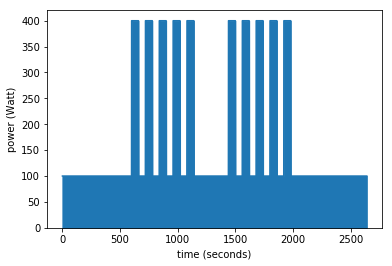

In [4]:
fig_power = wdf.power.plot.area()
fig_power.set_ylabel('power (Watt)')
fig_power.set_xlabel('time (seconds)');

In [5]:
wdf = wdf.assign(
    w_balance_skiba=wdf.compute_w_prime_balance('skiba'),
    w_balance_waterworth=wdf.compute_w_prime_balance('waterworth'),
    w_balance_froncioni_skiba_clarke=wdf.compute_w_prime_balance('froncioni-skiba-clarke'),
)

I will start with comparing the two versions of the integral algorithm. First the plot showing $W'_{bal}$ for both algorithms. This plot shows that the difference between these to algorithms is very small, with the Waterworth plot covering the original plot almost completely.

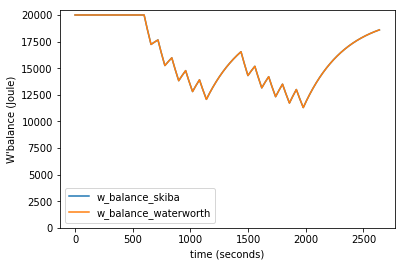

In [7]:
fig_skiba_waterworth = wdf.loc[:, ['w_balance_skiba', 'w_balance_waterworth']].plot(ylim=0)
fig_skiba_waterworth.set_ylabel('W\'balance (Joule)')
fig_skiba_waterworth.set_xlabel('time (seconds)');

When the residual plot for these two algorithms is plotted it is obvious that the algorithms are almost identical with the maximum difference equal to 5.46 nanojoule...

5.4569682106375694e-12

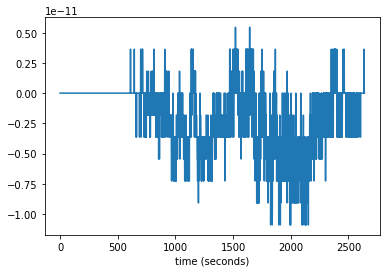

In [8]:
residuals = wdf.w_balance_skiba - wdf.w_balance_waterworth
fig_residuals = residuals.plot()
fig_residuals.set_xlabel('time (seconds)')
residuals.max()

Comparison of the integral algorithm with the differential algorithm reveals large differences between these two algorithms in the plot below. Both the expenditure and the recovery of $W'_{bal}$ are faster for the differential algorithm. The difference in the expenditure is especially striking because one would expect that it is linear and therefore identical for both algorithms. However, the difference can be explained by the fact that the integral algorithm assumes that although there is a netto decrease in $W'_{bal}$ for intervals where $P>CP$, there is also recovery of previously expended $W'$ during those intervals.

The difference in the recovery of $W'_{bal}$ is a consequence of how the recovery is modeled. For the integral algorithm this is done with the term $e^{-\frac{t-u}{\tau_{W'}}}$ in the equation, where $\tau_{W'}$ regulates the speed of recovery. My expectation is that for different values of $\tau_{W'}$ (or different values for the constants numbers 546, -0.01 and 316) the recovery can be changed to similar speed as the differential model. Similarly, the recovery speed in the differential model is regulated by the term $\frac{W' - W'_{bal}(t-1)}{W'}$ and it is possible to change the recovery speed by multiplying this term by e.g. a factor $\alpha$: $\alpha*\frac{W' - W'_{bal}(t-1)}{W'}$. Although this goes against one of the main reasons to develop the differential algorithm (to get rid of coefficients that have to be determined), I will try to fit this modified algorithm to the integral algorithm in a later article as a proof of concept.

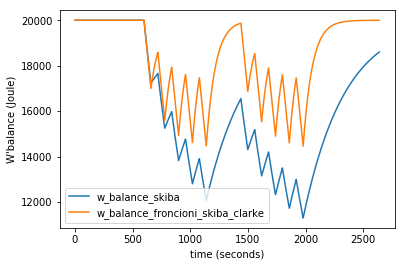

In [6]:
fig_skiba_froncioni = wdf.loc[:, ['w_balance_skiba', 'w_balance_froncioni_skiba_clarke']].plot()
fig_skiba_froncioni.set_ylabel('W\'balance (Joule)')
fig_skiba_froncioni.set_xlabel('time (seconds)');

## Conclusion

From the three algorithms that were compared, there were no differences between the original integral algorithm and the optimization of this algorithm by Waterworth. There were however big differences between both versions of the inegral algorithm and the differential algorithm, with the differential algorithm showing faster expenditure and recovery of $W_{bal}$. It would be interesting to see if these differences can be minimized by adding a model parameter to the differential algorithm and fitting it to the integral algorithm.

## References

1. Jones, A. M., & Vanhatalo, A. (2017). The ‘Critical Power’Concept: Applications to Sports Performance with a Focus on Intermittent High-Intensity Exercise. Sports Medicine, 47(1), 65-78.
2. Skiba, P. F., Chidnok, W., Vanhatalo, A., & Jones, A. M. (2012). Modeling the expenditure and reconstitution of work capacity above critical power. Medicine and science in sports and exercise, 44(8), 1526-1532.
3. http://markliversedge.blogspot.nl/2014/10/wbal-optimisation-by-mathematician.html
4. Skiba, P. F., Fulford, J., Clarke, D. C., Vanhatalo, A., & Jones, A. M. (2015). Intramuscular determinants of the ability to recover work capacity above critical power. European journal of applied physiology, 115(4), 703-713.
5. Skiba, P. F., Jackman, S., Clarke, D., Vanhatalo, A., & Jones, A. M. (2014). Effect of work and recovery durations on W'reconstitution during intermittent exercise. Medicine and science in sports and exercise, 46(7), 1433-1440.

## Exporting images

In [9]:
import numpy as np
figures = [fig_power, fig_skiba_waterworth, fig_residuals, fig_skiba_froncioni]
figure_names = ['fig_power', 'fig_skiba_waterworth', 'fig_residuals', 'fig_skiba_froncioni']
for fig, name in zip(figures, figure_names):
    if hasattr(fig, 'savefig'):
        f = fig
    elif isinstance(fig, np.ndarray):
        f = fig[0].get_figure()
    else:
        f = fig.get_figure()

    f.savefig(f'{name}.png', dpi=600)
